# Running trVAE on Haber dataset

In [1]:
import os
os.chdir("../")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import trvae

/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


In [3]:
sc.set_figure_params(dpi=200)

## Loading & preparing data

In [4]:
condition_key = "condition"
cell_type_key = "cell_label"

In [8]:
adata = sc.read("./data/processed/haber_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 9842 × 2000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Normalizing & Extracting Top 1000 Highly Variable Genes 
We can preserve more genes (up to 7000 like scGen) but in order to train the network quickly, we will extract top 1000 genes

In [9]:
#sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [10]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

In [11]:
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 9842 × 999 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Data Visualization

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/tf2/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


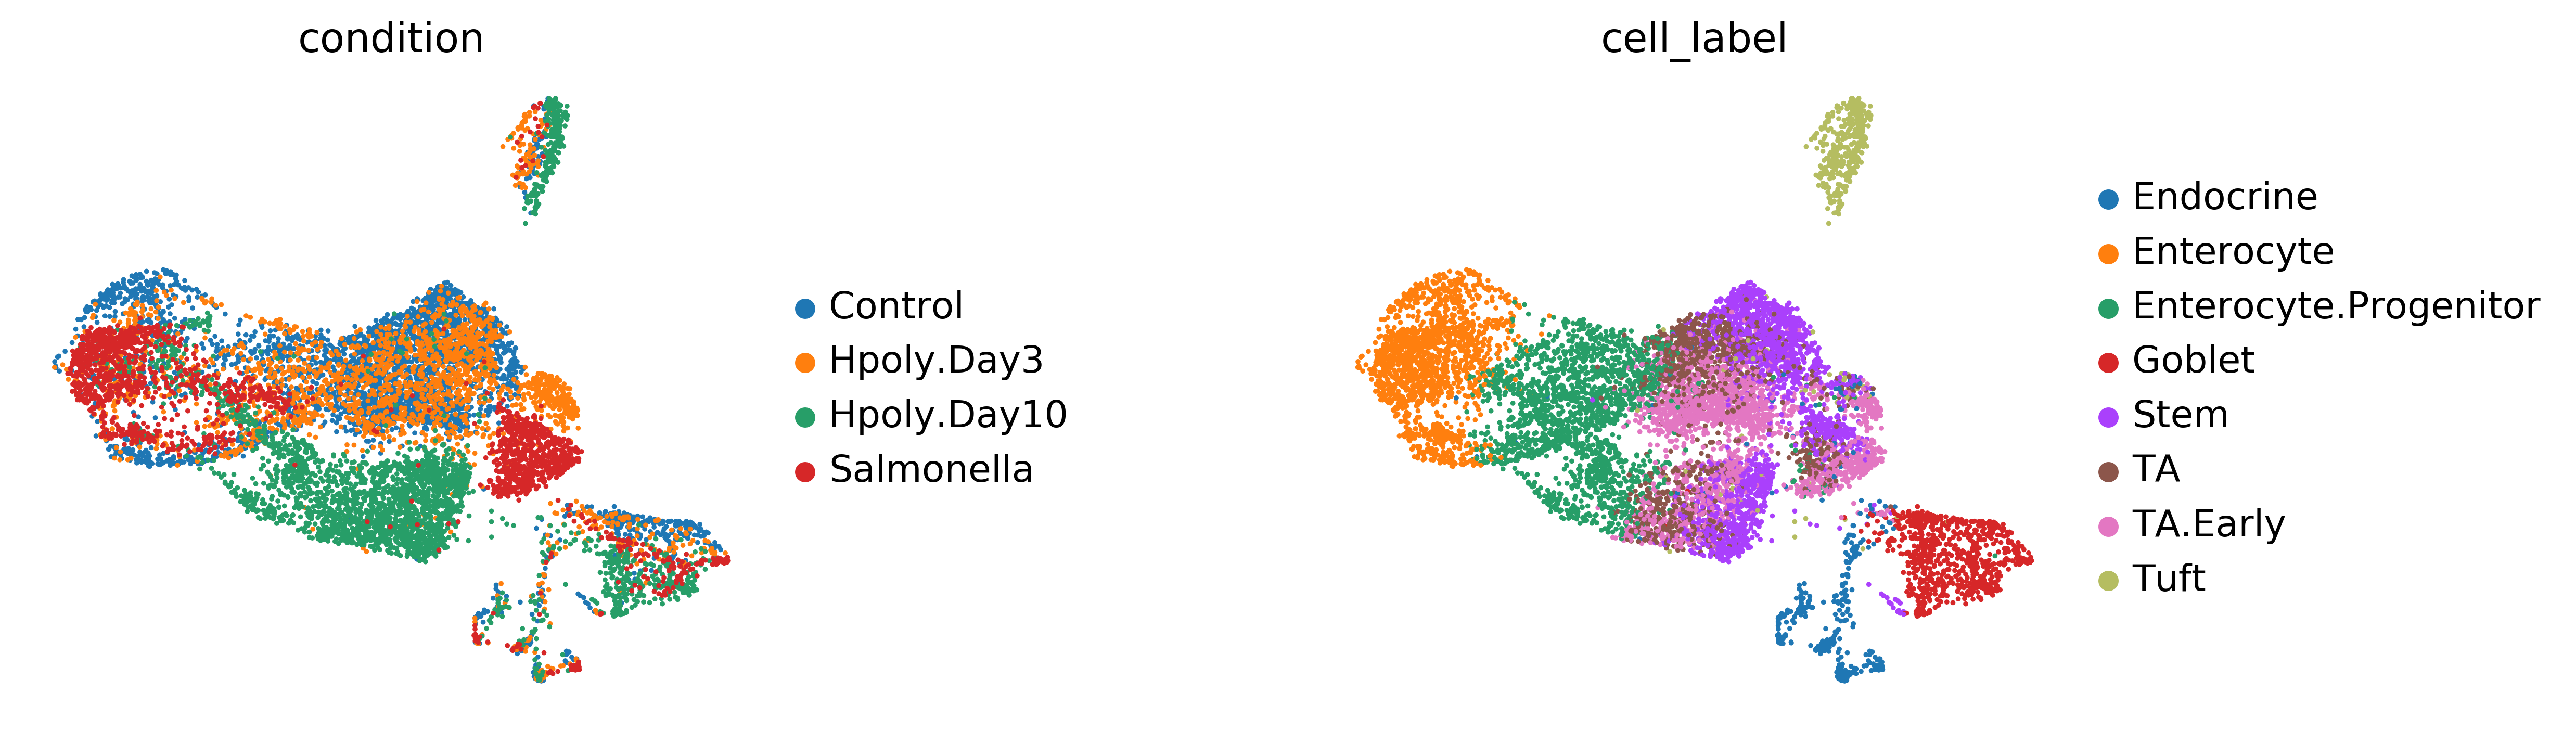

In [13]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], 
           wspace=0.6, 
           frameon=False)

## Train/Test Split

In [14]:
train_adata, valid_adata = trvae.utils.train_test_split(adata, train_frac=0.80)

In [15]:
train_adata.shape, valid_adata.shape

((7873, 999), (1969, 999))

In [16]:
net_train_adata = train_adata[~((train_adata.obs[condition_key] == 'Hpoly.Day10') & (train_adata.obs[cell_type_key] == 'Endocrine'))]
net_valid_adata = valid_adata[~((valid_adata.obs[condition_key] == 'Hpoly.Day10') & (valid_adata.obs[cell_type_key] == 'Endocrine'))]

In [17]:
net_train_adata.shape, net_valid_adata.shape

((7806, 999), (1954, 999))

## Calculate number of batches

In [18]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

In [19]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = trvae.utils.create_dictionary(conditions, [])
condition_encoder

{'Control': 0, 'Hpoly.Day3': 1, 'Hpoly.Day10': 2, 'Salmonella': 3}

## Create the network
Some of network parameters:
 - __x_dimension__: number of features (necessary)
 - __n_conditons__: total number of batches (necessary)
 - __architecture__: architecture of the network (optional)
 - __output_activation__: activation function of trVAE's last layer 
 - __alpha__: coefficient of KL Divergence loss (optional)
 - __beta__: coefficient of MMD loss (optional)
 - __eta__: coefficient of reconstruction (MSE or SSE) loss (optional)
     can be one of the `relu`, `leaky_relu`, `linear`, ... 

In [20]:
network = trvae.archs.trVAE(x_dimension=train_adata.shape[1],
                            architecture=[128, 32],
                            z_dimension=10,
                            n_conditions=n_conditions,
                            alpha=0.00005,
                            beta=50,
                            eta=100,
                            output_activation='relu')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 999)          0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          128512      concatenate_1[0][0]        

## Training trVAE
Parameters:
   - __train_adata__: `anndata` object for training trVAE
   - __valid_adata__: `anndata` object for validating trVAE (default = None)
   - __condition_key__: (`str`) name of the column containing batches' names in `train_adata` and `valid_adata` (Necessary)
   - __condition_encoder__: (`dict`) dictionary of encoded batches (keys: batch names, values: encoded integers) (default = None)
   - __verbose__: (`int`) level of verbosity (default = 0)

__NOTE: This will take 5 minutes in a single 1080ti Nvidia GPU__

In [ ]:
network.train(net_train_adata,
              net_valid_adata,
              condition_encoder,
              condition_key,
              n_epochs=1000,
              batch_size=1024,
              verbose=5,
              early_stop_limit=750,
              lr_reducer=0,
              shuffle=True,
              )

 |█-------------------| 5.0%  - loss: 775.1389 - kl_sse_loss: 771.2010 - mmd_loss: 5.4760 - val_loss: 728.5977 - val_kl_sse_loss: 723.5703 - val_mmd_loss: 4.85805322

/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


 |██████████----------| 51.7%  - loss: 585.3431 - kl_sse_loss: 582.3301 - mmd_loss: 2.8871 - val_loss: 541.6791 - val_kl_sse_loss: 538.7323 - val_mmd_loss: 2.9436

## Getting batch-corrected adata

In [19]:
labels, _ = trvae.tl.label_encoder(adata, condition_key=condition_key, label_encoder=condition_encoder)

In [20]:
network.get_corrected(adata, labels, return_z=True)

Now two matrices have been added to adata
 - __mmd_latent__: (`numpy ndarray`) output of MMD Layer in trVAE 
 - __reconstructed__: (`numpy ndarray`) reconstructed data with dimension of original feature space
 - __z_latent__: (`numpy ndarray`) output of bottleneck layer of trVAE (optional)
 
For evaluating how good trVAE has corrected the batches, we recommend using __mmd_latent__ matrix.

In [21]:
adata

AnnData object with n_obs × n_vars = 9842 × 1000 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'condition_colors', 'cell_label_colors'
    obsm: 'X_pca', 'X_umap', 'mmd_latent', 'reconstructed', 'z_latent'

## MMD Layer UMAP visualization

In [22]:
mmd_latent = adata.obsm['mmd_latent']
mmd_adata = sc.AnnData(mmd_latent, obs=adata.obs)
mmd_adata

AnnData object with n_obs × n_vars = 9842 × 32 
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'n_counts'

In [23]:
sc.pp.neighbors(mmd_adata)
sc.tl.umap(mmd_adata)

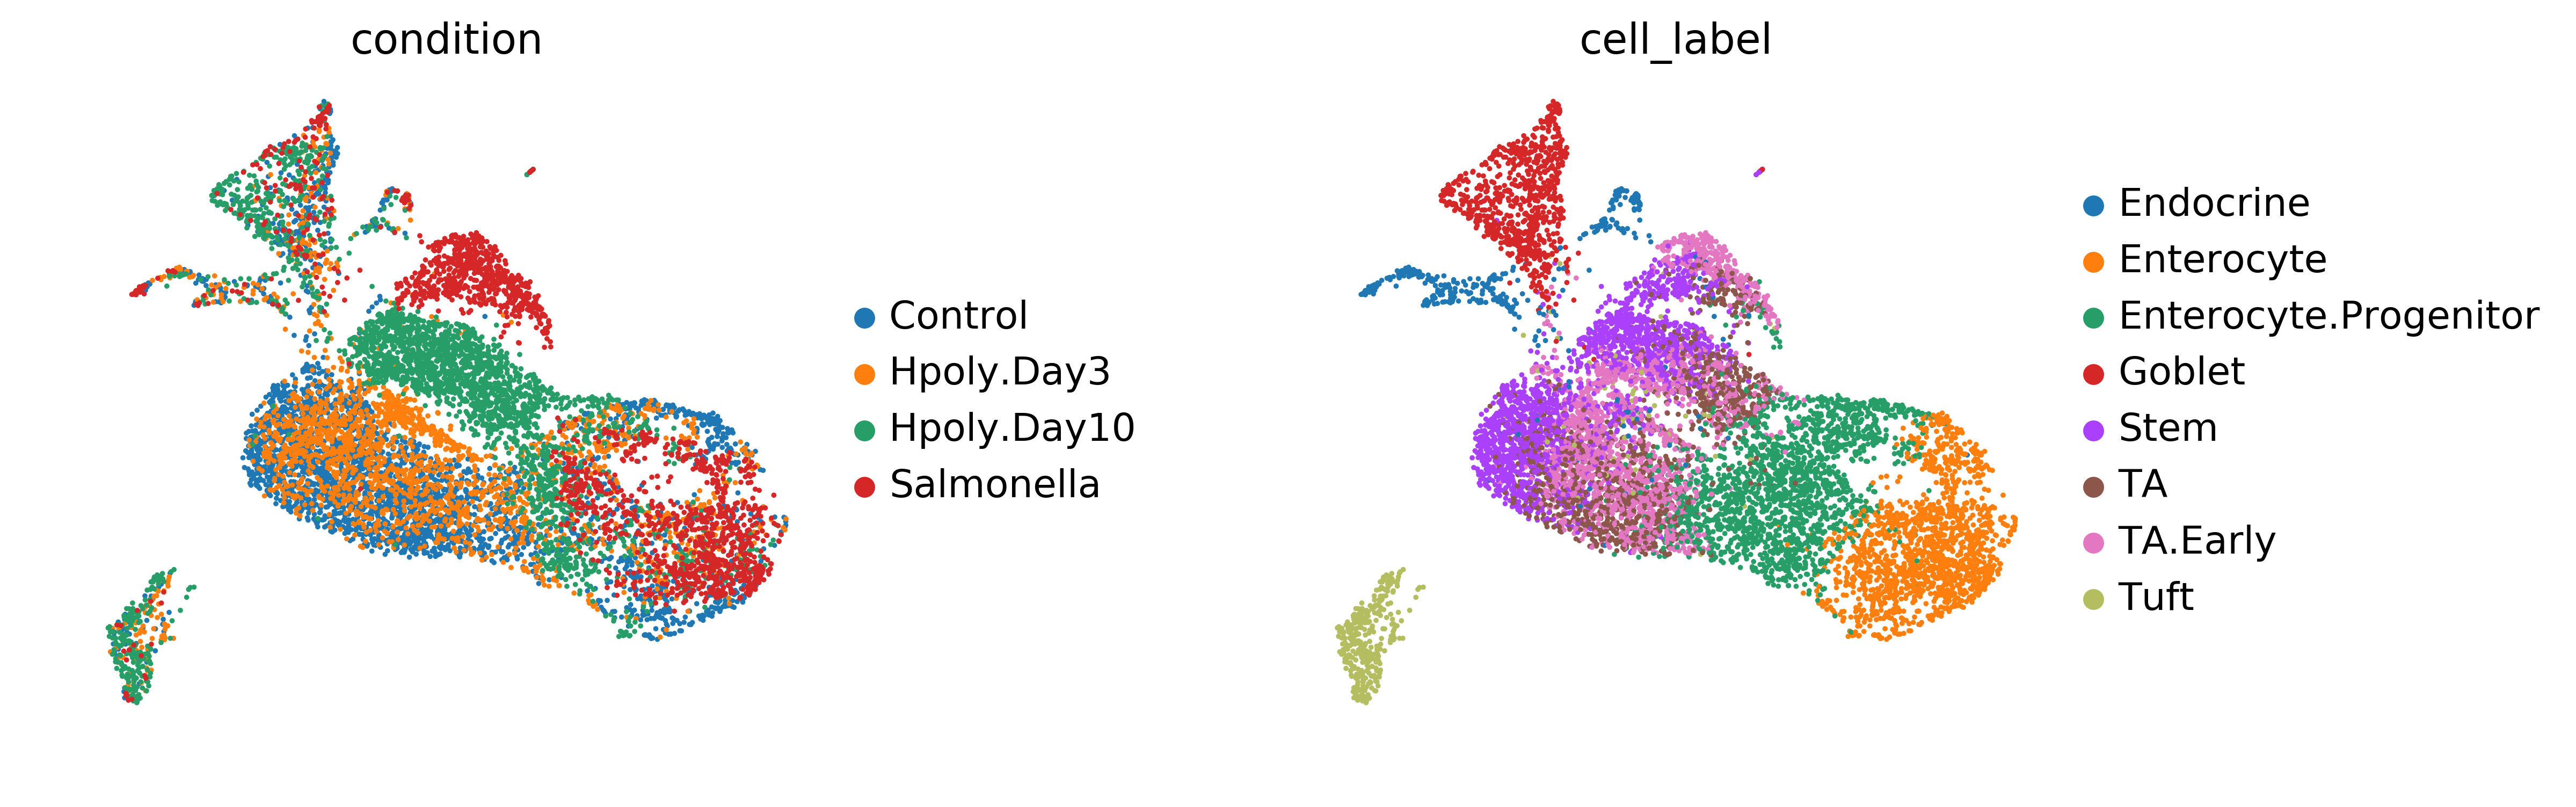

In [24]:
sc.pl.umap(mmd_adata, color=[condition_key, cell_type_key], wspace=0.5, frameon=False)